In [239]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colorbar import Colorbar
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.mlab as mlab

import scipy
from scipy import io
from scipy.stats import iqr, norm
from scipy.stats.kde import gaussian_kde

from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel

import glob
import re


def collector(path):
    '''Collects all IDL save data from a given path and stores each file as an element in a list.'''

    filenames = glob.glob(path)

    data = {'data': [scipy.io.readsav(filenames[i], python_dict=True) for i in range(
        len(filenames))], 'filenames': filenames}
    return data


def separator(data):
    '''Compiles data into separate lists of extended and point sources'''

    point_data = [[data['data'][i]['source_array'][j] for j in range(len(
        data['data'][i]['source_array'])) if data['data'][i]['source_array'][j][-2] is None] for i in range(len(data['data']))]

    extended_data = [[data['data'][i]['source_array'][j] for j in range(len(
        data['data'][i]['source_array'])) if data['data'][i]['source_array'][j][-2] is not None] for i in range(len(data['data']))]

    return {'extsources': extended_data, 'psources': point_data}


def pixelate(ra_zoom, dec_zoom, n_bins, ra_total, dec_total, flux_total):
    import numpy as np
    # Check to see which dimension is larger so that a square in ra,dec can
    # be returned
    if (ra_zoom[1] - ra_zoom[0]) > (dec_zoom[1] - dec_zoom[0]):
        zoom = ra_zoom
    else:
        zoom = dec_zoom

    # Find the size of the bins using the largest dimension and the num of bins
    binsize = (zoom[1] - zoom[0]) / n_bins

    # Create arrays for ra and dec that give the left side of each pixel
    spacing_dec = ((ra_zoom[1] - ra_zoom[0]) - (dec_zoom[1] - dec_zoom[0])) / 2.
    spacing_ra = ((dec_zoom[1] - dec_zoom[0]) - (ra_zoom[1] - ra_zoom[0])) / 2.

    ra_bin_array = (np.array(range(n_bins)) * binsize) + ra_zoom[0]
    dec_bin_array = (np.array(range(n_bins)) * binsize) + dec_zoom[0]
    '''
    if (ra_zoom[1] - ra_zoom[0]) > (dec_zoom[1] - dec_zoom[0]):
        dec_bin_array = (np.array(range(n_bins)) * binsize) + \
            dec_zoom[0] - spacing_dec
    if (ra_zoom[1] - ra_zoom[0]) < (dec_zoom[1] - dec_zoom[0]):
        ra_bin_array = (np.array(range(n_bins)) * binsize) + \
            ra_zoom[0] - spacing_ra
    '''
    # Create an empty array of pixels to be filled in the for loops
    pixels = np.zeros((len(ra_bin_array), len(dec_bin_array)))

    # Histogram components into ra bins
    ra_histogram = np.digitize(ra_total, ra_bin_array)
    # print ra_histogram

    # Begin for loop over both dimensions of pixels, starting with ra
    for bin_i in range(len(ra_bin_array)):
        # print range(len(ra_bin_array) -2
        # print "bin_i",bin_i
        # Find the indices that fall into the current ra bin slice
        ra_inds = np.where(ra_histogram == bin_i)
        # print "rainds", ra_inds[0]
        # print "lenrainds", len(ra_inds[0])

        # Go to next for cycle if no indices fall into current ra bin slice
        if len(ra_inds[0]) == 0:
            continue

        # Histogram components that fall into the current ra bin slice by dec
        # print "dectotindex", dec_total[ra_inds]
        # print "decbin", dec_bin_array
        dec_histogram = np.digitize(dec_total[ra_inds], dec_bin_array)
        # print "dechist",dec_histogram
        # Begin for loop by dec over ra bin slice
        for bin_j in range(len(dec_bin_array)):

            # Find the indicies that fall into the current dec bin
            dec_inds = np.where(dec_histogram == bin_j)

            # Go to next for cycle if no indices fall into current dec bin
            if len(dec_inds[0]) == 0:
                continue
            # Sum the flux components that fall into current ra/dec bin
            # print "bi",bin_i,bin_j
            # print "inds",ra_inds, dec_inds
            pixels[bin_i, bin_j] = np.sum(flux_total[ra_inds[0][dec_inds][0]])

    # Find the pixel centers in ra/dec for plotting purposes
    ra_pixel_centers = (np.arange(n_bins) * binsize) + \
        ra_zoom[0] + binsize / 2.
    dec_pixel_centers = (np.arange(n_bins) * binsize) + \
        dec_zoom[0] + binsize / 2.

    return pixels, ra_pixel_centers, dec_pixel_centers, spacing_ra, spacing_dec


def plotEO(data, sumI=50, binwidth=3, sigmawidth=10, EOid=None):

    separated = separator(data)

    # Converting binwidth in arcsec to degrees
    binwidth = binwidth * (1. / 3600.)
    # Converting binwidth in arcsec to degrees
    sigmawidth = sigmawidth * (1. / 3600.)

    indexed_point_sources_RA = [[separated['psources'][i][j]['RA']
                                 for j in range(len(separated['psources'][i]))]
                                for i in range(len(separated['psources']))]

    indexed_point_sources_DEC = [[separated['psources'][i][j]['DEC']
                                  for j in range(len(separated['psources'][i]))]
                                 for i in range(len(separated['psources']))]

    indexed_point_sources_I = [[separated['psources'][i][j]['FLUX']['I'][0]
                                for j in range(len(separated['psources'][i]))]
                               for i in range(len(separated['psources']))]

    indexed_point_sources_XX = [[separated['psources'][i][j]['FLUX']['XX'][0]
                                 for j in range(len(separated['psources'][i]))]
                                for i in range(len(separated['psources']))]

    indexed_point_sources_YY = [[separated['psources'][i][j]['FLUX']['YY'][0]
                                 for j in range(len(separated['psources'][i]))]
                                for i in range(len(separated['psources']))]

    indexed_EO_sources_RA = [[[separated['extsources'][i][j]['EXTEND']['RA'][k]
                               for k in range(len(separated['extsources'][i][j]['EXTEND']['RA']))]
                              for j in range(len(separated['extsources'][i]))]
                             for i in range(len(separated['extsources']))]

    indexed_EO_sources_DEC = [[[separated['extsources'][i][j]['EXTEND']['DEC'][k]
                                for k in range(len(separated['extsources'][i][j]['EXTEND']['DEC']))]
                               for j in range(len(separated['extsources'][i]))]
                              for i in range(len(separated['extsources']))]

    indexed_EO_sources_I = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['I'][0]
                              for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                             for j in range(len(separated['extsources'][i]))]
                            for i in range(len(separated['extsources']))]

    indexed_EO_sources_XX = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['XX'][0]
                               for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                              for j in range(len(separated['extsources'][i]))]
                             for i in range(len(separated['extsources']))]

    indexed_EO_sources_YY = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['YY'][0]
                               for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                              for j in range(len(separated['extsources'][i]))]
                             for i in range(len(separated['extsources']))]

    for i in range(len(data['data'])):
        for j in range(len(indexed_EO_sources_RA[i])):
            for k in range(len(indexed_EO_sources_RA[i][j])):
                if indexed_EO_sources_RA[i][j][k] > 180:
                    indexed_EO_sources_RA[i][j][k] -= 360
        for j in range(len(indexed_point_sources_RA[i])):
            if indexed_point_sources_RA[i][j] > 180:
                indexed_point_sources_RA[i][j] -= 360

    all_RA = [[indexed_point_sources_RA[i][j]
               for j in range(len(indexed_point_sources_RA[i]))] + [indexed_EO_sources_RA[i][j][k]
              for j in range(len(indexed_EO_sources_RA[i]))
              for k in range(len(indexed_EO_sources_RA[i][j]))]
              for i in range(len(data['data']))]

    all_DEC = [[indexed_point_sources_DEC[i][j]
                for j in range(len(indexed_point_sources_DEC[i]))] + [indexed_EO_sources_DEC[i][j][k]
               for j in range(len(indexed_EO_sources_DEC[i]))
               for k in range(len(indexed_EO_sources_DEC[i][j]))]
               for i in range(len(data['data']))]

    all_I = [[indexed_point_sources_I[i][j]
              for j in range(len(indexed_point_sources_I[i]))] + [indexed_EO_sources_I[i][j][k]
             for j in range(len(indexed_EO_sources_I[i]))
             for k in range(len(indexed_EO_sources_I[i][j]))]
             for i in range(len(data['data']))]

    all_XX = [[indexed_point_sources_XX[i][j]
               for j in range(len(indexed_point_sources_XX[i]))] + [indexed_EO_sources_XX[i][j][k]
              for j in range(len(indexed_EO_sources_XX[i]))
              for k in range(len(indexed_EO_sources_XX[i][j]))]
              for i in range(len(data['data']))]

    all_YY = [[indexed_point_sources_YY[i][j]
               for j in range(len(indexed_point_sources_YY[i]))] + [indexed_EO_sources_YY[i][j][k]
              for j in range(len(indexed_EO_sources_YY[i]))
              for k in range(len(indexed_EO_sources_YY[i][j]))]
              for i in range(len(data['data']))]

    all_beam = [np.asarray(np.asarray(all_XX[i]) + np.asarray(all_YY[i])) /
                np.asarray(all_I[i]) for i in range(len(data['data']))]

    kernel = Gaussian2DKernel(stddev=(sigmawidth / binwidth))
    semi_zoom = 100. / 60.
    pixelreplacement = 1e-5
    cmap = matplotlib.cm.get_cmap('gist_heat')

    for i in range(len(data['data'])):

        # ---------- Pixelating and convolving All Plot
        all_ra_zoom = [min(all_RA[i]), max(all_RA[i])]
        all_dec_zoom = [min(all_DEC[i]), max(all_DEC[i])]
        all_n_bins = min(int(max(max(all_RA[i]) - min(all_RA[i]), max(all_DEC[i]) - min(all_DEC[i])) / binwidth), 1024)
        all_ra_total = np.array(all_RA[i])
        all_dec_total = np.array(all_DEC[i])
        all_I_total = np.array(all_I[i])
        all_XX_total = np.array(all_XX[i])
        all_YY_total = np.array(all_YY[i])

        all_beam_total = np.array(all_beam[i])

        (all_pixels, all_ra_pixel_centers, all_dec_pixel_centers, spacing_ra, spacing_dec) = pixelate(
            all_ra_zoom, all_dec_zoom, all_n_bins, all_ra_total, all_dec_total, all_I_total)

        (all_pixels_contour, all_ra_pixel_centers_contour, all_dec_pixel_centers_contour, spacing_ra, spacing_dec) = pixelate(
            all_ra_zoom, all_dec_zoom, 50, all_ra_total, all_dec_total, all_beam_total)

        all_pixels[all_pixels == 0] = pixelreplacement
        all_convolved = convolve_fft(all_pixels, kernel)

        if EOid is None:
            sumI = sumI
        elif EOid is not None:
            sumI = 0

        all_ra_min, all_ra_max = min(all_RA[i]), max(all_RA[i])
        all_dec_min, all_dec_max = min(all_DEC[i]), max(all_DEC[i])
        all_spacing_ra, all_spacing_dec = ((all_ra_max - all_ra_min) - (
            all_dec_max - all_dec_min)) / 2., ((all_dec_max - all_dec_min) - (all_ra_max - all_ra_min)) / 2.
        if (all_ra_max - all_ra_min) > (all_dec_max - all_dec_min):
            all_dec_min, all_dec_max = min(
                all_DEC[i]) - all_spacing_dec, max(all_DEC[i]) - all_spacing_dec

        if (all_ra_max - all_ra_min) < (all_dec_max - all_dec_min):
            all_ra_min, all_ra_max = min(
                all_RA[i]) - all_spacing_ra, max(all_RA[i]) - all_spacing_ra

        for j in range(len(separated['extsources'][i])):

            EO_ra_min, EO_ra_max = min(indexed_EO_sources_RA[i][j]) - 0.01, max(
                indexed_EO_sources_RA[i][j]) + 0.01
            EO_dec_min, EO_dec_max = min(indexed_EO_sources_DEC[i][j]) - 0.01, max(
                indexed_EO_sources_DEC[i][j]) + 0.01
            EO_spacing_ra, EO_spacing_dec = ((EO_ra_max - EO_ra_min) - (
                EO_dec_max - EO_dec_min)) / 2., ((EO_dec_max - EO_dec_min) - (EO_ra_max - EO_ra_min)) / 2.
            hist_ra, hist_dec = indexed_EO_sources_RA[i][j], indexed_EO_sources_DEC[i][j]

            if (EO_ra_max - EO_ra_min) > (EO_dec_max - EO_dec_min):
                hist_dec = indexed_EO_sources_DEC[i][j] - EO_spacing_dec
            if (EO_ra_max - EO_ra_min) < (EO_dec_max - EO_dec_min):
                hist_ra = indexed_EO_sources_RA[i][j] - EO_spacing_ra

            if (EOid is not None) and (separated['extsources'][i][j]['ID'] != EOid):
                continue

            if (sum(indexed_EO_sources_I[i][j]) > sumI) and ((max(indexed_EO_sources_XX[i][j]) != 0) and (max(indexed_EO_sources_YY[i][j]) != 0)):
                # ---------- Pixelating and convolving EO Plot
                EO_ra_zoom = [EO_ra_min, EO_ra_max]
                EO_dec_zoom = [EO_dec_min, EO_dec_max]
                EO_ra_total = np.array(indexed_EO_sources_RA[i][j])
                EO_dec_total = np.array(indexed_EO_sources_DEC[i][j])
                EO_I_total = np.array(indexed_EO_sources_I[i][j])
                EO_n_bins = int(max(max(EO_ra_total) - min(EO_ra_total),
                                    max(EO_dec_total) - min(EO_dec_total)) / binwidth)

                (EO_pixels, EO_ra_pixel_centers, EO_dec_pixel_centers, spacing_ra, spacing_dec) = pixelate(
                    EO_ra_zoom, EO_dec_zoom, EO_n_bins, EO_ra_total, EO_dec_total, EO_I_total)

                # EO_pixels[EO_pixels == 0] = pixelreplacement
                EO_convolved = convolve(EO_pixels, kernel)

                # ---------- Pixelating and convolving EO Not Plot
                EO_not_ra_zoom = [EO_ra_min, EO_ra_max]
                EO_not_dec_zoom = [EO_dec_min, EO_dec_max]
                EO_not_ra_total = np.array(all_RA[i])
                EO_not_dec_total = np.array(all_DEC[i])
                EO_not_I_total = np.array(all_I[i])
                EO_not_n_bins = EO_n_bins

                (EO_not_pixels, EO_not_ra_pixel_centers, EO_not_dec_pixel_centers, spacing_ra, spacing_dec) = pixelate(
                    EO_not_ra_zoom, EO_not_dec_zoom, EO_not_n_bins, EO_not_ra_total, EO_not_dec_total, EO_not_I_total)

                EO_not_pixels[EO_not_pixels == 0] = pixelreplacement
                EO_not_convolved = convolve_fft(EO_not_pixels, kernel)

                # ---------- Pixelating and convolving Semi Plot
                semi_ra_zoom = [EO_ra_min - semi_zoom, EO_ra_max + semi_zoom]
                semi_dec_zoom = [EO_dec_min -
                                 semi_zoom, EO_dec_max + semi_zoom]
                semi_n_bins = min(int(max(
                    [semi_ra_zoom[1] - semi_ra_zoom[0], semi_dec_zoom[1] - semi_dec_zoom[0]]) / binwidth), 512)
                semi_ra_total = np.array(all_RA[i])
                semi_dec_total = np.array(all_DEC[i])
                semi_flux_total = np.array(all_I[i])

                (semi_pixels, semi_ra_pixel_centers, semi_dec_pixel_centers, spacing_ra, spacing_dec) = pixelate(
                    semi_ra_zoom, semi_dec_zoom, semi_n_bins, semi_ra_total, semi_dec_total, semi_flux_total)

                semi_pixels[semi_pixels == 0] = pixelreplacement
                semi_convolved = convolve_fft(semi_pixels, kernel)

                ############################################################################

                fig = plt.figure(figsize=(16.75 + .45, 9.75 + .2))
                fig.suptitle('EO Source {} from ObsID {}'.format(separated['extsources'][i][j]['ID'], [int(
                    s) for s in re.findall('\d+', data['filenames'][i])][0], separated['extsources'][i][j]['FREQ']), fontsize=20)

                gs = gridspec.GridSpec(5, 10, height_ratios=[1, 4, .25, .5, 4], width_ratios=[
                                       4, .25, 1, 4, .25, 1, 4, 1, 1, .25])
                gs.update(left=0.05, right=0.95, bottom=0,
                          top=0.9, wspace=0.05, hspace=0.05)

                ax1 = fig.add_subplot(gs[1, 0])

                all_plot = ax1.imshow(np.transpose(all_convolved), norm=LogNorm(vmin=pixelreplacement), origin="lower", interpolation="none", cmap=cmap, extent=[
                                      all_ra_pixel_centers[0], all_ra_pixel_centers[-1], all_dec_pixel_centers[0], all_dec_pixel_centers[-1]])

                contour_plot = ax1.contourf(np.transpose(all_pixels_contour), cmap=plt.cm.bone, alpha=.4, levels=np.linspace(min(all_beam_total), max(
                    all_beam_total), 6), extent=[all_ra_pixel_centers[0], all_ra_pixel_centers[-1], all_dec_pixel_centers[0], all_dec_pixel_centers[-1]])

                ax1.clabel(contour_plot, fontsize=8,
                           inline=False, colors='white', alpha=1)

                ax1.add_patch(patches.Rectangle((np.median(semi_ra_pixel_centers) - semi_zoom * .5, np.median(
                    semi_dec_pixel_centers) - semi_zoom * .5), semi_zoom, semi_zoom, fill=False, color='cyan'))

                ax1.set_xlabel('RA')
                ax1.set_ylabel('DEC')
                ax1.tick_params(size=6, labelsize=10)
                ax1.minorticks_on()
                ax1.set_xlim(ax1.get_xlim()[::-1])

                ax2 = fig.add_subplot(gs[1, 3])
                semi_plot = ax2.imshow(np.transpose(semi_convolved), norm=LogNorm(vmin=pixelreplacement), origin="lower", interpolation="none", cmap=cmap, extent=[
                                       semi_ra_pixel_centers[0], semi_ra_pixel_centers[-1], semi_dec_pixel_centers[0], semi_dec_pixel_centers[-1]])
                ax2.add_patch(patches.Rectangle((min(EO_ra_pixel_centers), min(EO_dec_pixel_centers)), (max(EO_ra_pixel_centers) - min(
                    EO_ra_pixel_centers)), (max(EO_dec_pixel_centers) - min(EO_dec_pixel_centers)), fill=False, color='yellow'))
                ax2.set_xlabel('RA')
                ax2.minorticks_on()
                ax2.set_xlim(ax2.get_xlim()[::-1])

                ra_lim = [min(EO_ra_total), max(EO_ra_total)]
                dec_lim = [min(EO_dec_total), max(EO_dec_total)]
                if (max(EO_ra_total) - min(EO_ra_total)) > (max(EO_dec_total) - min(EO_dec_total)):
                    dec_lim = [min(EO_dec_total), max(EO_dec_total) + (max(EO_ra_total) -
                               min(EO_ra_total)) - (max(EO_dec_total) - min(EO_dec_total))]
                elif (max(EO_ra_total) - min(EO_ra_total)) < (max(EO_dec_total) - min(EO_dec_total)):
                    ra_lim = [min(EO_ra_total), max(EO_ra_total) + (max(EO_dec_total) -
                              min(EO_dec_total)) - (max(EO_ra_total) - min(EO_ra_total))]

                ax3 = fig.add_subplot(gs[1, 6])

                #EO_not_plot = ax3.imshow(np.transpose(EO_not_convolved), norm=LogNorm(vmin=pixelreplacement), origin="lower", interpolation="none", cmap=plt.cm.bone, alpha=1, extent=[
                 #                        EO_ra_pixel_centers[0], EO_ra_pixel_centers[-1], EO_dec_pixel_centers[0], EO_dec_pixel_centers[-1]])
                                          
                EO_plot = ax3.imshow(np.transpose(EO_convolved), origin='lower', norm=LogNorm(vmin=pixelreplacement), interpolation="none", cmap=cmap, extent=[
                                    EO_ra_pixel_centers[0], EO_ra_pixel_centers[-1],\
                                    EO_dec_pixel_centers[0], EO_dec_pixel_centers[-1]])

                # if (max(indexed_EO_sources_RA[i][j]) - min(indexed_EO_sources_RA[i][j])) > (max(indexed_EO_sources_DEC[i][j])-min(indexed_EO_sources_DEC[i][j])):
                # EO_plot.set_extent([EO_ra_pixel_centers[-1], EO_ra_pixel_centers[0], \
                #    EO_dec_pixel_centers[0]-spacing,\
                #    EO_dec_pixel_centers[-1]-spacing])
                # set_corner_pixels(EO_plot, EO_ra_pixel_centers[-1], EO_ra_pixel_centers[0], EO_dec_pixel_centers[0], EO_dec_pixel_centers[-1])

                # ax3.set_title('Source ID: {}'.format(separated['extsources'][i][j]['ID']),fontsize=16)
                
                ax3.xaxis.set_ticks_position('bottom')
                ax3.yaxis.set_ticks_position('left')
                ax3.set_xlabel('ra')
                ax3.set_ylabel('dec')
                '''
                ax3.set_xticklabels([])
                ax3.set_yticklabels([])
                '''
                ax3.xaxis.grid(which="major", color='grey',\
                               linestyle='--', linewidth=.75, alpha=.5)
                ax3.yaxis.grid(which="major", color='grey',\
                               linestyle='--', linewidth=.75, alpha=.5)
                
                # ax3.set_xlabel(r'$\Delta$ {:.4G} arcmin'.format((max(EO_ra_total) - min(EO_ra_total))*60.), fontsize = 12)
                # ax3.set_ylabel(r'$\Delta$ {:.4G} arcmin'.format((max(EO_dec_total) - min(EO_dec_total))*60.), fontsize = 12)
                #ax3.set_xlim(ax3.get_xlim()[::-1])
                ax3.set_xlim(EO_ra_pixel_centers[-1], EO_ra_pixel_centers[0])
                ax3.set_ylim(EO_dec_pixel_centers[0], EO_dec_pixel_centers[-1])

                # ---------- Plotting Stokes Histograms
                stokes_hist_bins = 100
                
                ax4 = fig.add_subplot(gs[4, 0])
                ax4.hist(indexed_EO_sources_I[i][j], bins=stokes_hist_bins,
                         orientation='vertical', color='tomato', alpha=.75, edgecolor='k')
                ax4.set_title('EO Source: {} Stokes Intensity'.format(
                    separated['extsources'][i][j]['ID']), fontsize=16)
                ax4.set_xlabel(r'I')
                ax4.set_ylabel(r'Number of Sources')
                ax4.xaxis.grid(which="major", color='grey',
                               linestyle='--', linewidth=.75, alpha=.5)
                ax4.yaxis.grid(which="major", color='grey',
                               linestyle='--', linewidth=.75, alpha=.5)

                XX_hist = gaussian_kde(indexed_EO_sources_XX[i][j])
                YY_hist = gaussian_kde(indexed_EO_sources_YY[i][j])
                XXYY_range = max(max(indexed_EO_sources_XX[i][j]), max(
                    indexed_EO_sources_YY[i][j]))

                ax5 = fig.add_subplot(gs[4, 3])
                EO_scatter_plot = ax5.scatter(
                    hist_ra, hist_dec, s=50.5, c=indexed_EO_sources_I[i][j], cmap=cmap)

                # ax5.set_title('EO Source: {} Stokes XX'.format(separated['extsources'][i][j]['ID']),fontsize=16)
                ax5.set_xlim(EO_ra_pixel_centers[0], EO_ra_pixel_centers[-1])
                ax5.set_ylim(EO_dec_pixel_centers[0], EO_dec_pixel_centers[-1])
                ax5.set_xlabel('')
                ax5.set_ylabel('')
                ax5.tick_params(size=6, labelsize=10)
                ax5.minorticks_on()
                ax5.set_xlim(ax5.get_xlim()[::-1])

                ax6 = fig.add_subplot(gs[4, 6])
                EO_not_plot = ax6.imshow(np.transpose(EO_not_convolved), norm=LogNorm(vmin=pixelreplacement), origin="lower", interpolation="none", cmap=plt.cm.bone, alpha=1, extent=[
                                         EO_ra_pixel_centers[0], EO_ra_pixel_centers[-1], EO_dec_pixel_centers[0], EO_dec_pixel_centers[-1]])

                ax6.set_xlim(EO_ra_pixel_centers[0], EO_ra_pixel_centers[-1])
                ax6.set_ylim(EO_dec_pixel_centers[0], EO_dec_pixel_centers[-1])
                ax6.xaxis.set_ticks_position('none')
                ax6.yaxis.set_ticks_position('none')
                ax6.set_xlabel(r' ')
                ax6.set_ylabel(r' ')
                ax6.set_xticklabels([])
                ax6.set_yticklabels([])
                ax6.xaxis.grid(which="major", color='grey',
                               linestyle='--', linewidth=.75, alpha=.5)
                ax6.yaxis.grid(which="major", color='grey',
                               linestyle='--', linewidth=.75, alpha=.5)
                ax6.set_xlim(ax6.get_xlim()[::-1])

                # ---------- Plotting Circle

                d = (ra_lim[1] - ra_lim[0]) * 3600. / \
                    60.  # Degrees into arcmin
                r = d / 2.
                theta = 2. * np.pi

                dotter = fig.add_subplot(gs[0, 7], projection='polar')

                # dotter.add_patch(patches.Rectangle((0,0), radius = binwidth, fill=True,color='r'))

                circle = plt.Circle(
                    (0, 0), radius=1.5 / 60., transform=dotter.transData._b, color='r', alpha=0.4)
                dotter.set_rmax(
                    EO_ra_pixel_centers[-1] - EO_ra_pixel_centers[0])
                dotter.set_rticks([r])
                dotter.set_xticklabels(['3" relative to frame'])
                dotter.set_rlabel_position(135)
                dotter.grid(False)
                dotter.add_artist(circle)

                # ---------- Plotting imshow colorbars

                all_cbax = plt.subplot(gs[1, 1])
                all_cb = Colorbar(ax=all_cbax, mappable=all_plot,
                                  orientation='vertical', ticklocation='right')
                # all_cb.set_label(r'Janskies', labelpad=10)

                semi_cbax = plt.subplot(gs[1, 4])
                semi_cb = Colorbar(
                    ax=semi_cbax, mappable=semi_plot, orientation='vertical', ticklocation='right')
                # semi_cb.set_label(r'Janskies', labelpad=10)

                EO_cbax = plt.subplot(gs[1, 9])
                EO_cb = Colorbar(ax=EO_cbax, mappable=EO_plot,
                                 orientation='vertical', ticklocation='right')
                EO_cb.set_label(r'Janskies', labelpad=10)

                # ---------- Plotting RA and DEC histograms for EO Plot
                
                EO_hist_ra = plt.subplot(gs[0, 6])
                EO_hist_dec = plt.subplot(gs[1, 7])

                EO_hist_ra_bins = np.arange(
                    EO_ra_pixel_centers[0], EO_ra_pixel_centers[-1], max(binwidth, .0001))
                EO_hist_dec_bins = np.arange(
                    EO_dec_pixel_centers[0], EO_dec_pixel_centers[-1], max(binwidth, .0001))

                hist_I = indexed_EO_sources_I[i][j]

                ra_pdf = gaussian_kde(hist_ra)
                ra_pdf_range = np.linspace(
                    EO_ra_pixel_centers[0], EO_ra_pixel_centers[-1], len(hist_ra))

                dec_pdf = gaussian_kde(hist_dec)
                dec_pdf_range = np.linspace(
                    EO_dec_pixel_centers[0], EO_dec_pixel_centers[-1], len(hist_dec))

                EO_hist_ra.hist(hist_ra, bins=EO_hist_ra_bins, normed=1,
                                orientation='vertical', color='k', edgecolor='w')
                EO_hist_ra.plot(ra_pdf_range, ra_pdf(ra_pdf_range), 'r')

                EO_hist_ra.set_xlim(
                    EO_ra_pixel_centers[0], EO_ra_pixel_centers[-1])
                EO_hist_ra.set_xticks(np.linspace(
                    EO_ra_pixel_centers[0], EO_ra_pixel_centers[-1], 5))
                EO_hist_ra.set_yticklabels([])
                EO_hist_ra.set_xlabel(r'RA')
                EO_hist_ra.xaxis.set_label_position('top')
                EO_hist_ra.set_xlim(EO_hist_ra.get_xlim()[::-1])

                EO_hist_ra.xaxis.tick_top()
                EO_hist_ra.tick_params(
                    axis='x', which='both', bottom='off', top='on', labelbottom='off')
                EO_hist_ra.yaxis.set_ticks_position('none')
                EO_hist_ra.minorticks_on()
                EO_hist_ra.xaxis.grid(
                    which="major", color='k', linestyle='--', linewidth=.75, alpha=.75)
                EO_hist_ra.xaxis.grid(
                    which="minor", color='k', linestyle='--', linewidth=.5, alpha=.5)
                # EO_hist_ra.set_ylim(EO_hist_ra.get_ylim()[::-1])

                EO_hist_dec.hist(hist_dec, bins=EO_hist_dec_bins, normed=1,
                                 orientation='horizontal', color='k', edgecolor='w')
                EO_hist_dec.plot(dec_pdf(dec_pdf_range), dec_pdf_range, 'r')

                EO_hist_dec.set_xlim()
                EO_hist_dec.set_ylim(
                    EO_dec_pixel_centers[0], EO_dec_pixel_centers[-1])
                EO_hist_dec.set_yticks(np.linspace(
                    EO_dec_pixel_centers[0], EO_dec_pixel_centers[-1], 5))
                EO_hist_dec.set_xticklabels([])
                EO_hist_dec.set_ylabel(r'DEC')
                EO_hist_dec.yaxis.tick_right()
                EO_hist_dec.xaxis.set_ticks_position('none')
                EO_hist_dec.tick_params(
                    axis='y', which='both', left='off', right='on')
                EO_hist_dec.minorticks_on()
                EO_hist_dec.yaxis.grid(
                    which="major", color='k', linestyle='--', linewidth=.75, alpha=.75)
                EO_hist_dec.yaxis.grid(
                    which="minor", color='k', linestyle='--', linewidth=.5, alpha=.5)
                
                ###################################################

                databox1 = plt.subplot(gs[4, 0])
                databox2 = plt.subplot(gs[4, 3])

                databox1.annotate("Source ID: {}\nEO Source Count: {}\nMean RA: {}\nMean Dec: {}".format(separated['extsources'][i][j]['ID'], len(indexed_EO_sources_I[i][j]), "{:.4G}".format(
                    separated['extsources'][i][j]['RA']), "{:.4G}".format(separated['extsources'][i][j]['DEC'])), xy=(0, .925), xytext=(0, 0), xycoords=('axes fraction', 'figure fraction'), textcoords='offset points', size=18, ha='left', va='top')
                # bbox=dict(boxstyle="square", fc="w"))

                databox2.annotate("Total Intensity: {}\nTotal Apparent Intensity: {}\nBeam Value: {}".format("{:.4G}".format(np.sum(indexed_EO_sources_I[i][j])), "{:.4G}".format(np.sum(indexed_EO_sources_XX[i][j]) + np.sum(indexed_EO_sources_YY[i][j])), "{:.4G}".format(
                    (np.sum(indexed_EO_sources_XX[i][j]) + np.sum(indexed_EO_sources_YY[i][j])) / np.sum(indexed_EO_sources_I[i][j]))), xy=(0, .925), xytext=(0, 0), xycoords=('axes fraction', 'figure fraction'), textcoords='offset points', size=18, ha='left', va='top')
                
                #print 'IN LOOP: EO_ra_min = {}'.format(EO_ra_min)
                # plt.savefig('/home/champ6/uwchamp2017/EOplots/EO'+'{}'.format(separated['extsources'][i][j]['ID'])+'.png', bbox_inches='tight')
    
                print 'spacing_ra = {}'.format(spacing_ra)
                print 'EO_spacing_ra = {}'.format(EO_spacing_ra)
                print 'EO_ra_zoom = {}'.format(EO_ra_zoom)
                print 'EO_ra_min = {}'.format(EO_ra_min)
                print 'EO_ra_max = {}'.format(EO_ra_max)
                print 'EO_ra_min should be {}'.format(min(indexed_EO_sources_RA[0][334]))
                print 'spacing_dec = {}'.format(spacing_dec)
                print 'EO_spacing_dec = {}'.format(EO_spacing_dec)
                print 'EO_dec_zoom = {}'.format(EO_dec_zoom)
                print 'EO_dec_min = {}'.format(EO_dec_min)
                print 'EO_dec_max = {}'.format(EO_dec_max)
                print 'EO_dec_min should be {}'.format(min(indexed_EO_sources_DEC[0][334]))
                print "j = {}".format(j)
    return plt.show()
    #print EO_ra_pixel_centers

spacing_ra = 0.0434169769287
EO_spacing_ra = -0.0434169769287
EO_ra_zoom = [81.291902770996089, 81.41621948242188]
EO_ra_min = 81.291902771
EO_ra_max = 81.4162194824
EO_ra_min should be 88.1109542847
spacing_dec = -0.0434169769287
EO_spacing_dec = 0.0434169769287
EO_dec_zoom = [-32.751073608398436, -32.539922943115236]
EO_dec_min = -32.7510736084
EO_dec_max = -32.5399229431
EO_dec_min should be -29.5819606781
j = 13


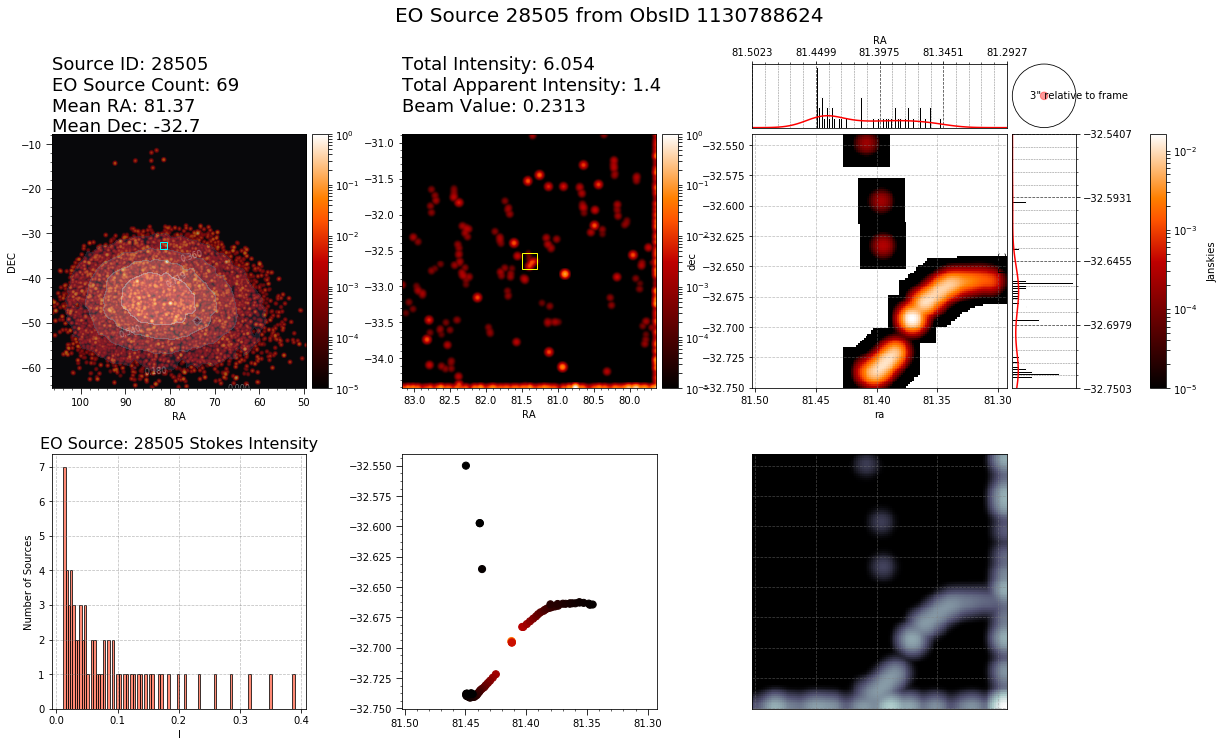

In [240]:
plotEO(data,binwidth=5,sigmawidth=15,EOid=28505)

In [151]:
separ = separator(data)

for i in range(len(separ['extsources'][0])):
    if separ['extsources'][0][i][0] == 30268:
        print 'i = {}'.format(i)
        for j in range(len(separ['extsources'][0][i]['extend'])):
            print 'elem: {}, comp: {}, ra: {}, dec: {}, intensity: {}'.format(i,j,separ['extsources'][0][i]['extend'][j]['ra'],\
                  separ['extsources'][0][i]['extend'][j]['dec'],separ['extsources'][0][i]['extend'][j]['flux']['i'][0])
            

i = 334
elem: 334, comp: 0, ra: 88.1123275757, dec: -29.5682430267, intensity: 0.100914254785
elem: 334, comp: 1, ra: 88.1112442017, dec: -29.5691623688, intensity: 0.0913470908999
elem: 334, comp: 2, ra: 88.1109542847, dec: -29.5685539246, intensity: 0.0811007842422
elem: 334, comp: 3, ra: 88.1115112305, dec: -29.5679950714, intensity: 0.0732442960143
elem: 334, comp: 4, ra: 88.1194076538, dec: -29.5245323181, intensity: 0.0719422623515
elem: 334, comp: 5, ra: 88.112701416, dec: -29.5819606781, intensity: 0.0653754845262


In [183]:
data = collector('new_source_arrays/1130788624_source_array.sav')

In [67]:
#BE CAREFUL!

#WOOOOO I DID IT! I made Devin's code only show the image of the EO, so now I can compare it to the ds9 images

def pixelater(ra_zoom, dec_zoom, n_bins, ra_total, dec_total, flux_total):
    import numpy as np
    #Check to see which dimension is larger so that a square in ra,dec can 
    #be returned
    if (ra_zoom[1]-ra_zoom[0]) > (dec_zoom[1]-dec_zoom[0]):
        zoom = ra_zoom
    else:
        zoom = dec_zoom

    #Find the size of the bins using the largest dimension and the num of bins
    binsize = (zoom[1]-zoom[0])/n_bins

    #Create arrays for ra and dec that give the left side of each pixel
    spacing_dec = ((ra_zoom[1]-ra_zoom[0]) - (dec_zoom[1]-dec_zoom[0]))/2.
    spacing_ra = ((dec_zoom[1]-dec_zoom[0])-(ra_zoom[1]-ra_zoom[0]))/2.
    
    ra_bin_array = (np.array(range(n_bins)) * binsize) + ra_zoom[0]
    dec_bin_array = (np.array(range(n_bins)) * binsize) + dec_zoom[0]
    
    
    #hashing this out restores this to the original pixelate function.
    
    if (ra_zoom[1]-ra_zoom[0]) > (dec_zoom[1]-dec_zoom[0]):
        dec_bin_array = (np.array(range(n_bins)) * binsize) + dec_zoom[0] - spacing_dec
    if (ra_zoom[1]-ra_zoom[0]) < (dec_zoom[1]-dec_zoom[0]):
        ra_bin_array = (np.array(range(n_bins)) * binsize) + ra_zoom[0] - spacing_ra
      
    
    #Create an empty array of pixels to be filled in the for loops
    pixels = np.zeros((len(ra_bin_array),len(dec_bin_array)))

    #Histogram components into ra bins
    ra_histogram = np.digitize(ra_total,ra_bin_array)
    ###print ra_histogram

    #Begin for loop over both dimensions of pixels, starting with ra
    for bin_i in range(len(ra_bin_array) - 2):
        ###print range(len(ra_bin_array) -2
        ###print "bin_i",bin_i
        #Find the indices that fall into the current ra bin slice
        ra_inds = np.where(ra_histogram == bin_i)
        ###print "rainds", ra_inds[0]
        ###print "lenrainds", len(ra_inds[0])

        #Go to next for cycle if no indices fall into current ra bin slice
        if len(ra_inds[0]) == 0:
            continue

        #Histogram components that fall into the current ra bin slice by dec
        #print "dectotindex", dec_total[ra_inds]
        #print "decbin", dec_bin_array
        dec_histogram = np.digitize(dec_total[ra_inds],dec_bin_array)
        #print "dechist",dec_histogram
        #Begin for loop by dec over ra bin slice
        for bin_j in range(len(dec_bin_array) -2):
            
            #Find the indicies that fall into the current dec bin
            dec_inds = np.where(dec_histogram == bin_j)

            #Go to next for cycle if no indices fall into current dec bin			
            if len(dec_inds[0]) == 0:
                continue
            #Sum the flux components that fall into current ra/dec bin
            ###print "bi",bin_i,bin_j
            ###print "inds",ra_inds, dec_inds
            pixels[bin_i,bin_j] = np.sum(flux_total[ra_inds[0][dec_inds][0]])

    #Find the pixel centers in ra/dec for plotting purposes
    ra_pixel_centers = (np.arange(n_bins) * binsize) + ra_zoom[0] + binsize/2.
    dec_pixel_centers = (np.arange(n_bins) * binsize) + dec_zoom[0] + binsize/2.

    return pixels, ra_pixel_centers, dec_pixel_centers, spacing_dec, spacing_ra

def devin(data,minI=3,sumI=50,binwidth=3,sigmawidth=10,EOid=None):
    from matplotlib.colors import LogNorm
    from matplotlib.colorbar import Colorbar
    import matplotlib.patches as patches
    from scipy.stats import iqr
    from scipy.stats.kde import gaussian_kde
    import matplotlib.gridspec as gridspec
    import re
    from astropy.convolution import convolve, convolve_fft
    from astropy.convolution import Gaussian2DKernel
    import matplotlib.pyplot as plt
    from scipy.stats import norm
    import matplotlib.mlab as mlab
    
    separated = separator(data)
    
    binwidth = binwidth * (1./3600.) #Converting binwidth in arcsec to degrees
    sigmawidth = sigmawidth * (1./3600.) #Converting binwidth in arcsec to degrees
    
    indexed_point_sources_RA = [[separated['psources'][i][j]['RA'] \
        for j in range(len(separated['psources'][i]))] \
            for i in range(len(separated['psources'])) ]

    indexed_point_sources_DEC = [[separated['psources'][i][j]['DEC'] \
        for j in range(len(separated['psources'][i]))] \
            for i in range(len(separated['psources'])) ]

    indexed_point_sources_I = [[separated['psources'][i][j]['FLUX']['I'][0] \
        for j in range(len(separated['psources'][i]))] \
            for i in range(len(separated['psources'])) ]
    
    indexed_point_sources_XX = [[separated['psources'][i][j]['FLUX']['XX'][0] \
        for j in range(len(separated['psources'][i]))] \
            for i in range(len(separated['psources'])) ]
    
    indexed_point_sources_YY = [[separated['psources'][i][j]['FLUX']['YY'][0] \
        for j in range(len(separated['psources'][i]))] \
            for i in range(len(separated['psources'])) ]

    indexed_EO_sources_RA = [[[separated['extsources'][i][j]['EXTEND']['RA'][k] \
        for k in range(len(separated['extsources'][i][j]['EXTEND']['RA']))] \
            for j in range(len(separated['extsources'][i]))] \
                for i in range(len(separated['extsources'])) ]

    indexed_EO_sources_DEC = [[[separated['extsources'][i][j]['EXTEND']['DEC'][k] \
        for k in range(len(separated['extsources'][i][j]['EXTEND']['DEC']))] \
            for j in range(len(separated['extsources'][i]))] \
                for i in range(len(separated['extsources'])) ]

    indexed_EO_sources_I = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['I'][0] \
        for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX'])) ] \
            for j in range(len(separated['extsources'][i]))] \
                for i in range(len(separated['extsources'])) ]
    
    indexed_EO_sources_XX = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['XX'][0] \
        for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX'])) ] \
            for j in range(len(separated['extsources'][i]))] \
                for i in range(len(separated['extsources'])) ]
    
    indexed_EO_sources_YY = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['YY'][0] \
        for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX'])) ] \
            for j in range(len(separated['extsources'][i]))] \
                for i in range(len(separated['extsources'])) ]
    
    for i in range(len(data['data'])):
        for j in range(len(indexed_EO_sources_RA[i])):
            for k in range(len(indexed_EO_sources_RA[i][j])):
                if indexed_EO_sources_RA[i][j][k] > 180:
                    indexed_EO_sources_RA[i][j][k] -= 360
        for j in range(len(indexed_point_sources_RA[i])):
            if indexed_point_sources_RA[i][j] > 180:
                indexed_point_sources_RA[i][j] -= 360    
    
    all_RA = [[indexed_point_sources_RA[i][j] \
        for j in range(len(indexed_point_sources_RA[i]))] \
        + [indexed_EO_sources_RA[i][j][k] \
        for j in range(len(indexed_EO_sources_RA[i])) \
        for k in range(len(indexed_EO_sources_RA[i][j]))] \
            for i in range(len(data['data'])) ]
    
    all_DEC = [[indexed_point_sources_DEC[i][j] \
        for j in range(len(indexed_point_sources_DEC[i]))] \
        + [indexed_EO_sources_DEC[i][j][k] \
        for j in range(len(indexed_EO_sources_DEC[i])) \
        for k in range(len(indexed_EO_sources_DEC[i][j]))] \
            for i in range(len(data['data'])) ]
    
    all_I = [[indexed_point_sources_I[i][j] \
        for j in range(len(indexed_point_sources_I[i]))] \
        + [indexed_EO_sources_I[i][j][k] \
        for j in range(len(indexed_EO_sources_I[i])) \
        for k in range(len(indexed_EO_sources_I[i][j]))] \
            for i in range(len(data['data'])) ]
    
    all_XX = [[indexed_point_sources_XX[i][j] \
        for j in range(len(indexed_point_sources_XX[i]))] \
        + [indexed_EO_sources_XX[i][j][k] \
        for j in range(len(indexed_EO_sources_XX[i])) \
        for k in range(len(indexed_EO_sources_XX[i][j]))] \
            for i in range(len(data['data'])) ]
    
    all_YY = [[indexed_point_sources_YY[i][j] \
        for j in range(len(indexed_point_sources_YY[i]))] \
        + [indexed_EO_sources_YY[i][j][k] \
        for j in range(len(indexed_EO_sources_YY[i])) \
        for k in range(len(indexed_EO_sources_YY[i][j]))] \
            for i in range(len(data['data'])) ]
    
    all_beam = [np.asarray(np.asarray(all_XX[i]) + np.asarray(all_YY[i])) / np.asarray(all_I[i]) for i in range(len(data['data']))]
    #print all_beam[0]
    #print all_beam[1]
    
    kernel = Gaussian2DKernel(stddev=(sigmawidth/binwidth))
    semi_zoom = 3
    pixelreplacement = 1e-5
    cmap = matplotlib.cm.get_cmap('gist_heat')

    for i in range(len(data['data'])):
        
        #---------- Pixelating and convolving All Plot
        all_ra_zoom = [min(all_RA[i]),max(all_RA[i])]
        all_dec_zoom = [min(all_DEC[i]),max(all_DEC[i])]
        all_n_bins = min(int(max(max(all_RA[i]) - min(all_RA[i]),max(all_DEC[i]) - min(all_DEC[i])) / binwidth),1024)
        all_ra_total = np.array(all_RA[i])
        all_dec_total = np.array(all_DEC[i])
        all_I_total = np.array(all_I[i])
        all_XX_total = np.array(all_XX[i])
        all_YY_total = np.array(all_YY[i])
        
        all_beam_total = np.array(all_beam[i])
        
        (all_pixels, all_ra_pixel_centers, all_dec_pixel_centers, spacing_dec, spacing_ra) = \
                pixelater(all_ra_zoom,all_dec_zoom,all_n_bins,all_ra_total,all_dec_total,all_I_total)
            
        (all_pixels_contour, all_ra_pixel_centers_contour, all_dec_pixel_centers_contour, spacing_dec, spacing_ra) = \
                    pixelater(all_ra_zoom,all_dec_zoom,50,all_ra_total,all_dec_total,all_beam_total)
        
        all_pixels[all_pixels == 0] = pixelreplacement
        all_convolved = convolve_fft(all_pixels, kernel)
        if EOid != None:
            minI, sumI = 0, 0
            
        
        for j in range(len(separated['extsources'][i])):
            if (EOid is not None) and (separated['extsources'][i][j]['ID'] != EOid):
                continue
                
            elif ((max(indexed_EO_sources_I[i][j]) > minI) or (sum(indexed_EO_sources_I[i][j]) > sumI))\
            and ((max(indexed_EO_sources_XX[i][j]) != 0) and (max(indexed_EO_sources_YY[i][j]) != 0)):
                #---------- Pixelating and convolving EO Plot
                EO_ra_zoom = [min(indexed_EO_sources_RA[i][j]),max(indexed_EO_sources_RA[i][j])]
                EO_dec_zoom = [min(indexed_EO_sources_DEC[i][j]),max(indexed_EO_sources_DEC[i][j])]                
                EO_ra_total = np.array(indexed_EO_sources_RA[i][j])
                EO_dec_total = np.array(indexed_EO_sources_DEC[i][j])
                EO_I_total = np.array(indexed_EO_sources_I[i][j])
                
                EO_n_bins = int(max(max(EO_ra_total) - min(EO_ra_total),max(EO_dec_total) - min(EO_dec_total)) / binwidth)
                #print EO_n_bins
                #print separated['extsources'][i][j]['ID']
                (EO_pixels, EO_ra_pixel_centers, EO_dec_pixel_centers, spacing_dec, spacing_ra) = \
                pixelater(EO_ra_zoom,EO_dec_zoom,EO_n_bins,EO_ra_total,EO_dec_total,EO_I_total)
                
                EO_pixels[EO_pixels == 0] = pixelreplacement
                EO_convolved = convolve_fft(EO_pixels, kernel)
                #---------- Pixelating and convolving Semi Plot
                semi_ra_zoom = [min(indexed_EO_sources_RA[i][j])-semi_zoom,max(indexed_EO_sources_RA[i][j])+semi_zoom]
                semi_dec_zoom = [min(indexed_EO_sources_DEC[i][j])-semi_zoom,max(indexed_EO_sources_DEC[i][j])+semi_zoom]
                semi_n_bins = min(int(max([semi_ra_zoom[1]-semi_ra_zoom[0],semi_dec_zoom[1]-semi_dec_zoom[0]])/binwidth),512)
                semi_ra_total = np.array(all_RA[i])
                semi_dec_total = np.array(all_DEC[i])
                semi_flux_total = np.array(all_I[i])

                (semi_pixels, semi_ra_pixel_centers, semi_dec_pixel_centers, spacing_dec, spacing_ra) = \
                        pixelater(semi_ra_zoom,semi_dec_zoom,semi_n_bins,semi_ra_total,semi_dec_total,semi_flux_total)

                semi_pixels[semi_pixels == 0] = pixelreplacement
                semi_convolved = convolve_fft(semi_pixels, kernel)
                
                ############################################################################
                
                
                
                
                
                fig = plt.figure(figsize=(25,25))
                fig.suptitle('EO Source {} from ObsID {}'.format\
                    (separated['extsources'][i][j]['ID'],\
                    [int(s) for s in re.findall('\d+',data['filenames'][i])][0],\
                    separated['extsources'][i][j]['FREQ']), fontsize = 20)
                
                gs = gridspec.GridSpec(2, 2, height_ratios=[1,1], width_ratios=[1,2])
                #gs.update(left=0.05, right=0.95, bottom=0, top=0.9, wspace=0.05, hspace=0.05)
                
                
                ax1 = fig.add_subplot(gs[0,0])
                
                EO_plot = ax1.imshow(np.transpose(EO_convolved), \
                    norm = LogNorm(vmin=pixelreplacement),\
                    origin = "lower", interpolation = "none", cmap = cmap,\
                    extent = [EO_ra_pixel_centers[0] - spacing_ra, EO_ra_pixel_centers[-1] - spacing_ra, \
                    EO_dec_pixel_centers[0], EO_dec_pixel_centers[-1]])
                
                #contour_plot = ax1.contour(np.transpose(EO_convolved), cmap=plt.cm.bone, alpha=.4, extent=[EO_ra_pixel_centers[0], EO_ra_pixel_centers[-1], \
                #EO_dec_pixel_centers[0], EO_dec_pixel_centers[-1]] )
                
                ax1.set_xlabel('RA')
                ax1.set_ylabel('DEC')
                ax1.minorticks_on()
                ax1.set_title('Plot of EO from MWA data: {}'.format(separated['extsources'][i][j]['ID']),fontsize=16)
                
                #ax1.annotate('ra range: ({},{})'.format(EO_ra_pixel_centers[0], EO_ra_pixel_centers[-1]),xy=(65.1,32.2))#/n
                #'dec range: ({},{})'.format(EO_dec_pixel_centers[0], EO_dec_pixel_centers[-1]))
                
                #X, Y = np.meshgrid(indexed_EO_sources_RA[i][j], indexed_EO_sources_DEC[i][j])
                
                #plt.contour(EO_convolved)
                
                #ax1.xaxis.set_ticks_position('none')
                #ax1.yaxis.set_ticks_position('none')
                '''
                ax1.set_xlabel(r' ')
                ax1.set_ylabel(r' ')
                ax1.set_xticklabels([])
                ax1.set_yticklabels([])
                ax1.set_xlabel(r'$\Delta$ {:.4G} arcmin'.format((max(EO_ra_total) - min(EO_ra_total))*60.), fontsize = 12)
                ax1.set_ylabel(r'$\Delta$ {:.4G} arcmin'.format((max(EO_dec_total) - min(EO_dec_total))*60.), fontsize = 12)
                '''
                ax1.set_xlim(ax1.get_xlim()[::-1])
                
                #this block is to be uncommented when image files are used
                
                
                import matplotlib.image as mpimg
                img1=mpimg.imread('plotsfromfv/624_28721/624_28721_rangecontours.ps')           #these are the files from fv
                img2=mpimg.imread('plotsfromfv/624_28721/624_28721_objfull.ps')           #to compare with MWA
                #img3=mpimg.imread('')
                
                ax2 = fig.add_subplot(gs[0,1])
                thing1 = ax2.imshow(img1)
                
                ax2.minorticks_off()
                ax2.axes.get_xaxis().set_visible(False)
                ax2.axes.get_yaxis().set_visible(False)
                ax2.set_title('EO in TGSS (Same RA/DEC Range)')
                '''
            
                ax3 = fig.add_subplot(gs[1,0])
                thing2 = ax3.imshow(img3)
                ax3.minorticks_off()
                ax3.axes.get_xaxis().set_visible(False)
                ax3.axes.get_yaxis().set_visible(False)
                ax3.set_title('EO in TGSS (0.5 square degrees, centered)')
                '''
                ax4 = fig.add_subplot(gs[1,1])
                thing3 = ax4.imshow(img2)
                ax4.minorticks_off()
                ax4.axes.get_xaxis().set_visible(False)
                ax4.axes.get_yaxis().set_visible(False)
                ax4.set_title('EO in TGSS (Same RA/DEC Range, Contours)')
                
                fig.tight_layout()
                
                print 'ra range: ({},{})'.format(EO_ra_pixel_centers[0], EO_ra_pixel_centers[-1])
                print 'dec range: ({},{})'.format(EO_dec_pixel_centers[0], EO_dec_pixel_centers[-1])
                print spacing_dec, spacing_ra
                
                
                #plt.savefig('/home/champ8/uwchamp2017/EOplots304/EO'+'{}'.format(separated['extsources'][i][j]['ID'])+'.png', bbox_inches='tight')
    return plt.show()

In [81]:
separ['extsources'][0][334]['extend']

rec.array([ (30268,  1160.7857666 ,  1330.94238281,  88.11232758, -29.56824303,  0.,  182.43501282, -0.80000001,  0.1, 0, None, rec.array([( 0.00365608,  0.00324113,  0.+0.j,  0.+0.j,  0.10091425,  0.,  0.,  0.)], 
          dtype=[(('xx', 'XX'), '>f4'), (('yy', 'YY'), '>f4'), (('xy', 'XY'), '>c8'), (('yx', 'YX'), '>c8'), (('i', 'I'), '>f4'), (('q', 'Q'), '>f4'), (('u', 'U'), '>f4'), (('v', 'V'), '>f4')])),
 (30268,  1160.76586914,  1330.92626953,  88.1112442 , -29.56916237,  0.,  182.43501282, -0.80000001,  0.1, 0, None, rec.array([( 0.00330947,  0.00293385,  0.+0.j,  0.+0.j,  0.09134709,  0.,  0.,  0.)], 
          dtype=[(('xx', 'XX'), '>f4'), (('yy', 'YY'), '>f4'), (('xy', 'XY'), '>c8'), (('yx', 'YX'), '>c8'), (('i', 'I'), '>f4'), (('q', 'Q'), '>f4'), (('u', 'U'), '>f4'), (('v', 'V'), '>f4')])),
 (30268,  1160.76306152,  1330.93798828,  88.11095428, -29.56855392,  0.,  182.43501282, -0.80000001,  0.1, 0, None, rec.array([( 0.00293825,  0.00260477,  0.+0.j,  0.+0.j,  0.08110078,  0.

In [80]:
separ['extsources'][0][334]['extend'][4].dtype

dtype((numpy.record, [(('id', 'ID'), '>i4'), (('x', 'X'), '>f4'), (('y', 'Y'), '>f4'), (('ra', 'RA'), '>f4'), (('dec', 'DEC'), '>f4'), (('ston', 'STON'), '>f4'), (('freq', 'FREQ'), '>f4'), (('alpha', 'ALPHA'), '>f4'), (('gain', 'GAIN'), '>f4'), (('flag', 'FLAG'), '>i2'), (('extend', 'EXTEND'), 'O'), (('flux', 'FLUX'), 'O')]))

ra range: (88.1110936739,88.1682432554)
dec range: (-29.5818212889,-29.5246717073)
-0.0244874954224 0.0244874954224


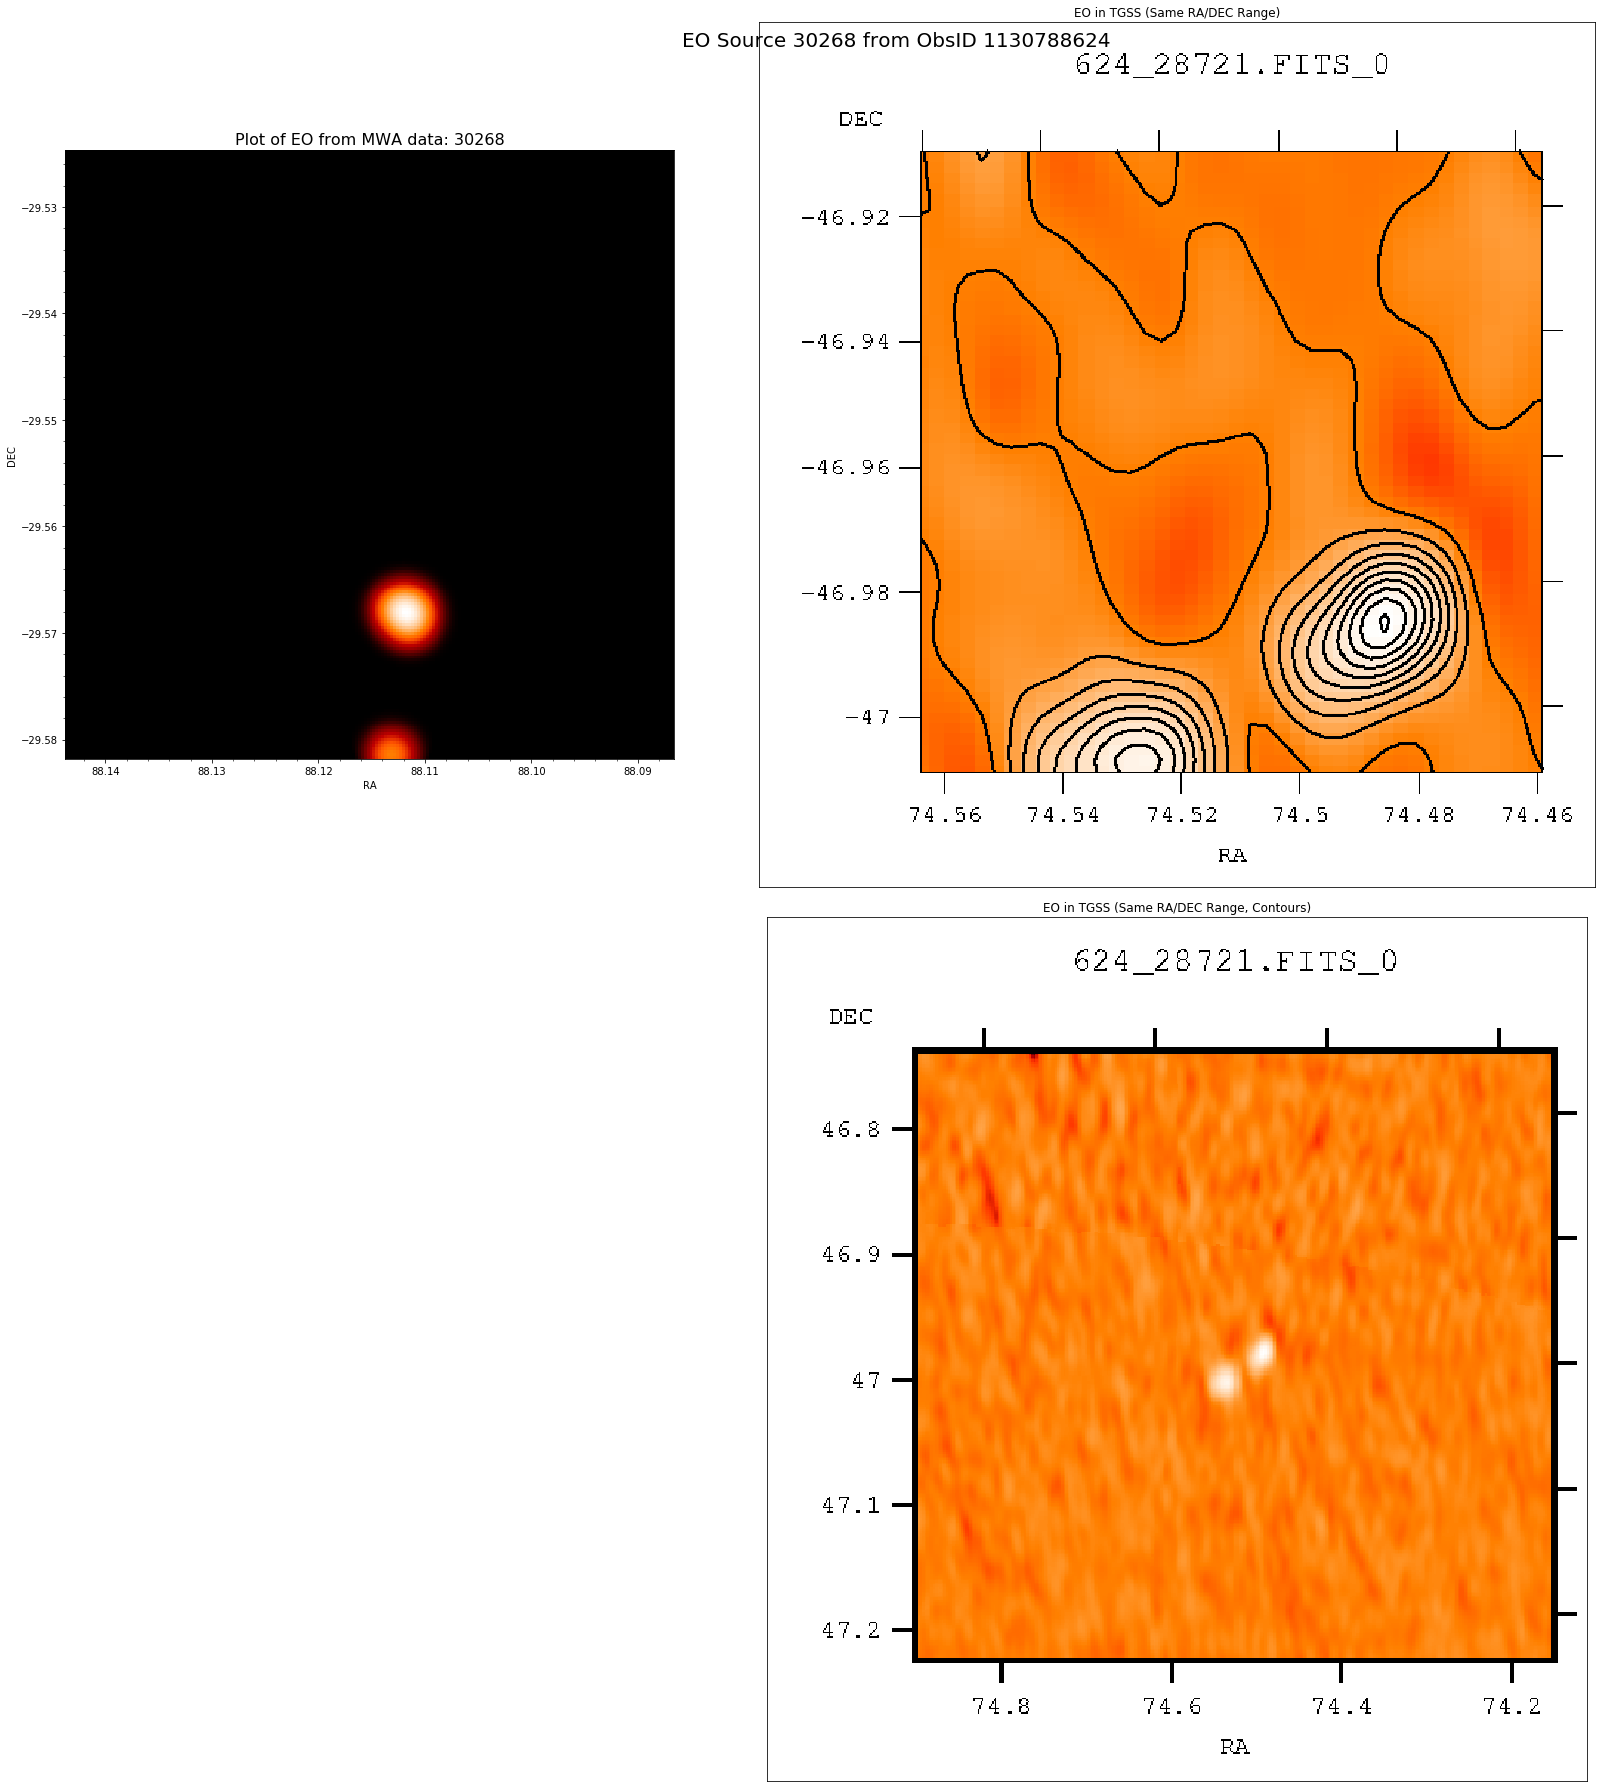

In [69]:
devin(data,binwidth=1,sigmawidth=4,EOid=30268)

In [85]:
EO_ra_pixel_centers

NameError: name 'EO_ra_pixel_centers' is not defined